### Архитектура модели

In [34]:
import torch
from torch import nn
torch.manual_seed(0)

In [35]:
class FruitNet(nn.Module):
    
    def __init__(self):
        super(FruitNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            nn.ReLU()
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(128 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 131)
        
        self.activation = nn.Softmax(dim=0)

        
    def forward(self, image):
        
        image = self.conv1(image)
        image = self.conv2(image)
        image = self.conv3(image)
        image = self.conv4(image)
        
        image = image.view(-1, 128 * 7 * 7)
        
        image = self.fc1(image)
        image = self.fc2(image)
        image = self.fc3(image)
        
        return image


### Создаём pandas датасеты для удобства работы с данными

In [36]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [37]:
def create_dataset_from_folder(folder_name: str) -> pd.DataFrame:
    
    images = []
    
    for root, dirs, files in os.walk(os.path.join("/kaggle/input/fruits/fruits-360_dataset/fruits-360", folder_name)):

        mark = root[root.rfind("/") + 1 :]

        if len(files) > 0:
            for file in files:
                images.append([f"{root}/{file}", mark])
    
    ds = pd.DataFrame(data=images, columns=["filename", "class"])
    return ds

In [ ]:
train = create_dataset_from_folder("Training")
test = create_dataset_from_folder("Test")

In [ ]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [38]:
train = pd.read_csv("/kaggle/input/fruits-pandas/train .csv")
test = pd.read_csv("/kaggle/input/fruits-pandas/test.csv")

In [39]:
encoder = LabelEncoder().fit(train["class"])
train["class"] = encoder.transform(train["class"])
test["class"] = encoder.transform(test["class"])

### Создаём кастомный pytorch датасет

In [40]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [41]:
class FruitDataset(Dataset):
    
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        filename = self.df.loc[idx, "filename"]
        img = Image.open(filename).convert('RGB')
        to_tensor = transforms.ToTensor()
        
        mark = self.df.loc[idx, "class"]
        
        #class_tensor = torch.zeros(131)
        #class_tensor[mark] = 1
        
        return to_tensor(img), mark

In [42]:
val, test = train_test_split(test, test_size=0.4, random_state=42, stratify=test["class"])
val = val.reset_index()
test = test.reset_index()

In [60]:
train_ds = FruitDataset(train)
val_ds = FruitDataset(val)
test_ds = FruitDataset(test)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1024, shuffle=True, num_workers=2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=2)

### Подготовили данные, теперь обучение модели

In [44]:
from copy import deepcopy
from math import inf
from tqdm import tqdm
from time import time_ns
from torch.optim.lr_scheduler import StepLR

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [48]:
model = FruitNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [49]:
loaders = { "train": train_dl, "val": val_dl }
history = { "train": [], "val": [] }

best_model = deepcopy(model.state_dict())
best_loss = inf

In [52]:
max_epochs = 15

for epoch in tqdm(range(max_epochs)):
    
    start = time_ns() * 1e-9
    
    train_losses = []
    validation_losses = []
    

    for k, dataloader in loaders.items():

        for img, mark in dataloader:
            
            img = img.to(device)
            mark = mark.to(device)
            
            optimizer.zero_grad()
            
            if k == "train":
                model.train()
                output = model(img)
            else:
                model.eval()
                with torch.no_grad():
                    output = model(img)
            
            if k == "train":
                loss = criterion(output, mark)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.detach().to("cpu").item())
            else:
                with torch.no_grad():
                    loss = criterion(output, mark)
                    validation_losses.append(loss.detach().to("cpu").item())
    
    lr_scheduler.step()
    train_avg_loss = sum(train_losses) / len(train_losses)
    history["train"].append(train_avg_loss)
    
    val_avg_loss = sum(validation_losses) / len(validation_losses)
    history["val"].append(val_avg_loss)
    
    if val_avg_loss < best_loss:
        best_loss = val_avg_loss
        best_model = deepcopy(model.state_dict())
    
    end = time_ns() * 1e-9    
    tqdm.write(f"Iteration №{epoch + 1}. Train CrossEntropyLoss: {train_avg_loss}. Val CrossEntropyLoss: {val_avg_loss}. Time used: {end - start}.")

 20%|██        | 1/5 [01:02<04:08, 62.25s/it]

Iteration №11. Train CrossEntropyLoss: 0.0008943659959729316. Val CrossEntropyLoss: 0.2413178916488375. Time used: 62.238587617874146.


 40%|████      | 2/5 [02:04<03:06, 62.14s/it]

Iteration №12. Train CrossEntropyLoss: 0.0008629682637167289. Val CrossEntropyLoss: 0.23815215804747172. Time used: 62.05012273788452.


 60%|██████    | 3/5 [03:06<02:04, 62.21s/it]

Iteration №13. Train CrossEntropyLoss: 0.000818154017906636. Val CrossEntropyLoss: 0.24109804843153274. Time used: 62.28639531135559.


 80%|████████  | 4/5 [04:09<01:02, 62.39s/it]

Iteration №14. Train CrossEntropyLoss: 0.0007960978524460554. Val CrossEntropyLoss: 0.24016412666865758. Time used: 62.664268493652344.


100%|██████████| 5/5 [05:13<00:00, 62.60s/it]

Iteration №15. Train CrossEntropyLoss: 0.0007425310305639435. Val CrossEntropyLoss: 0.23644146216767176. Time used: 63.75047016143799.


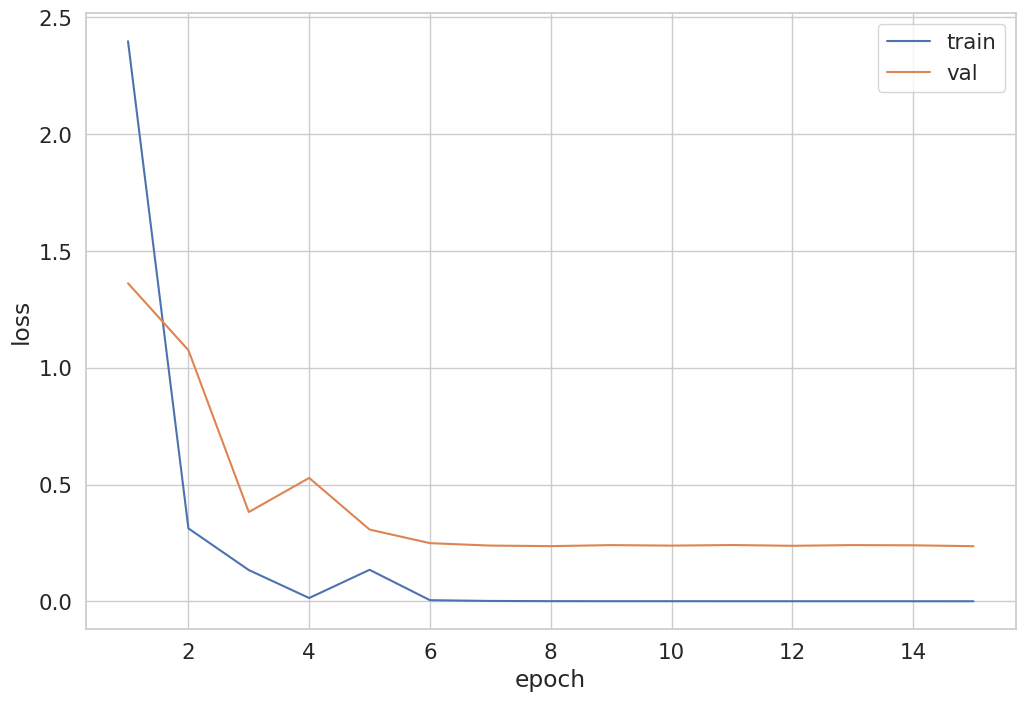

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

X = [i for i in range(1, len(history["train"]) + 1)]

sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(X, history["train"], label="train")
plt.plot(X, history["val"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### Метрики

In [61]:
from sklearn.metrics import classification_report

In [62]:
def score(model, dataloader, device, criterion):
    
    model.to(device)
    model.eval()
    
    losses = []
    
    for img, mark in tqdm(dataloader, total=len(dataloader)):
       
            
            img = img.to(device)
            mark = mark.to(device)
            
            optimizer.zero_grad()

            with torch.no_grad():
                output = model(img)
                loss = criterion(output, mark)
            
            losses.append(loss.detach().to("cpu").item())
    
    return sum(losses) / len(losses)

In [57]:
score(model, test_dl, device, criterion)

100%|██████████| 9/9 [00:27<00:00,  3.09s/it]


0.2377167112297482

In [74]:
def predict(model, dataloader, device):
    model.to(device)
    model.eval()
    
    results = torch.tensor([])
    
    for img, mark in tqdm(dataloader, total=len(dataloader)):
        img = img.to(device)
        mark = mark.to(device)
            
        optimizer.zero_grad()

        with torch.no_grad():
            output = model(img)
        
        
        results = torch.cat((results, torch.argmax(output.to("cpu").detach(), dim=1)))
    return results

results = predict(model, test_dl, device)

100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


In [83]:
y_pred = results.numpy()
y_true = test["class"]

In [88]:
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

                     precision    recall  f1-score   support

     Apple Braeburn       0.80      0.73      0.76        66
 Apple Crimson Snow       1.00      1.00      1.00        59
     Apple Golden 1       1.00      0.97      0.98        64
     Apple Golden 2       1.00      1.00      1.00        66
     Apple Golden 3       0.98      1.00      0.99        64
 Apple Granny Smith       1.00      1.00      1.00        66
    Apple Pink Lady       0.96      0.84      0.89        61
        Apple Red 1       0.86      0.73      0.79        66
        Apple Red 2       0.88      0.92      0.90        66
        Apple Red 3       0.80      0.91      0.85        58
Apple Red Delicious       0.99      1.00      0.99        66
 Apple Red Yellow 1       1.00      0.94      0.97        66
 Apple Red Yellow 2       0.94      0.97      0.96        88
            Apricot       0.97      1.00      0.99        66
            Avocado       1.00      1.00      1.00        57
       Avocado ripe    

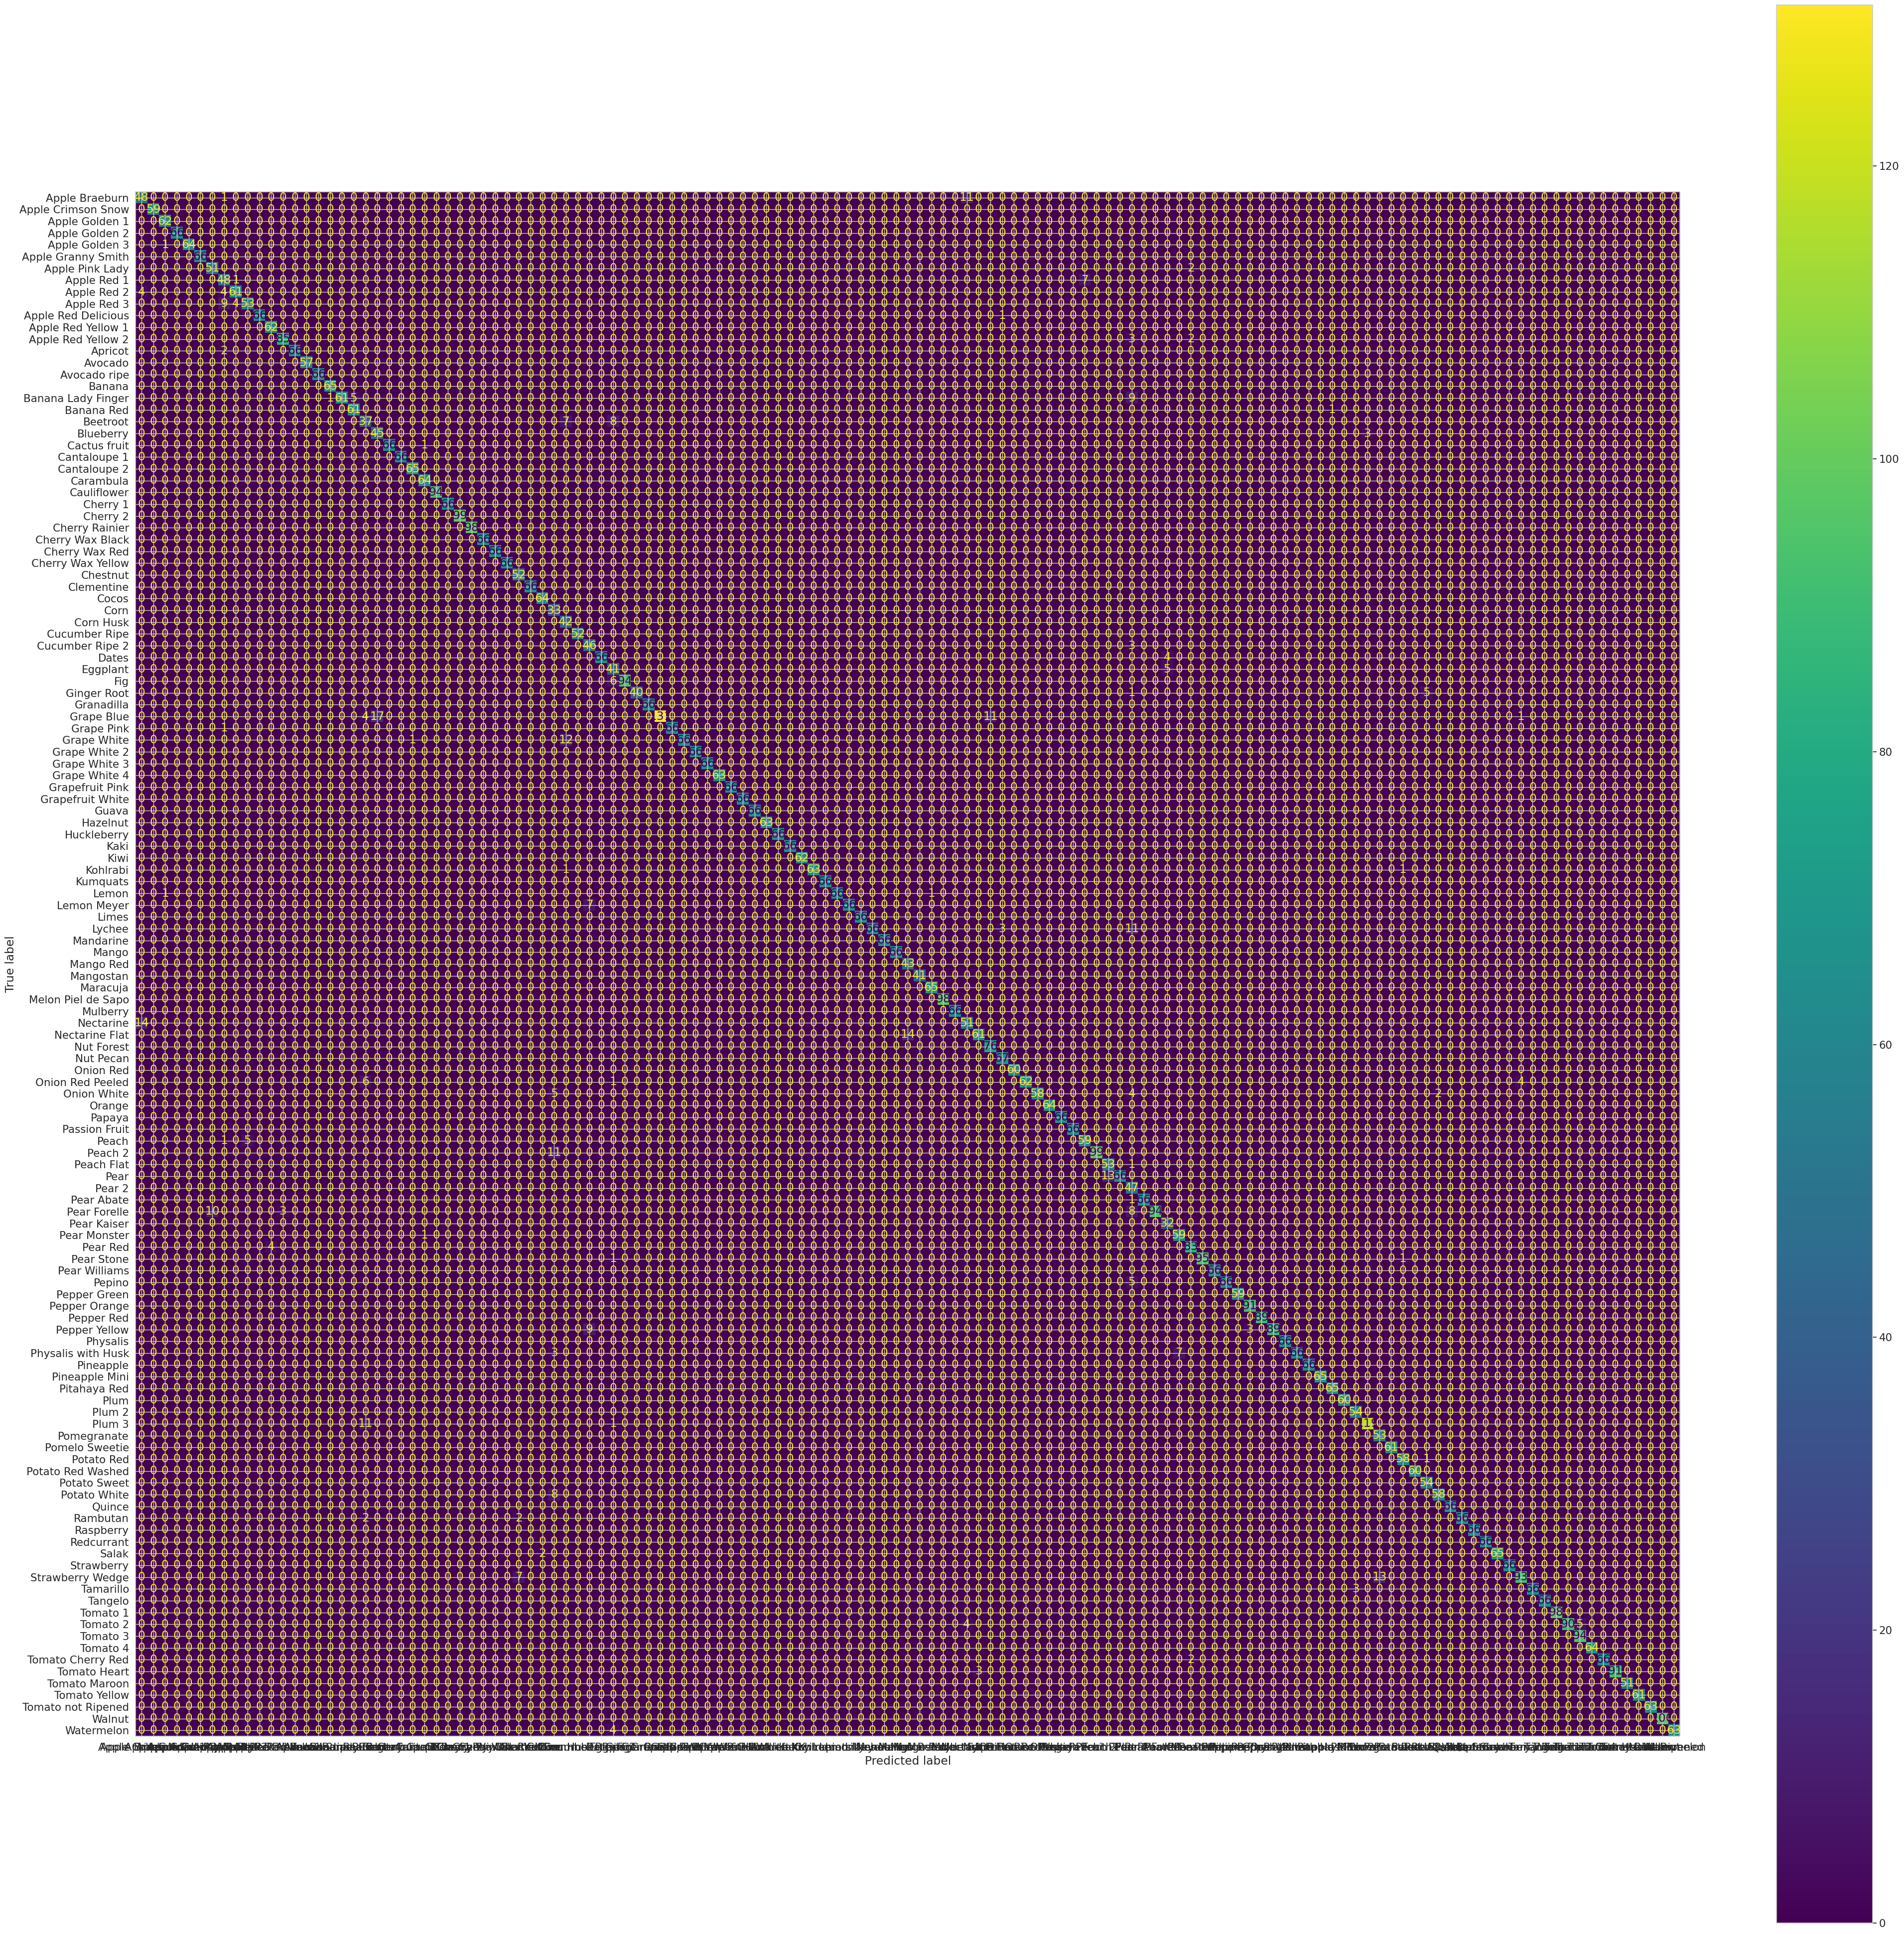

In [100]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_pred, y_true)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = encoder.classes_)

fig, ax = plt.subplots(figsize=(50,50))
cm_display.plot(ax=ax)
plt.show()